### Messing around with plots
This works best for my by running
`jupyter notebook viz_exploratory` from command line
and ensuring that the same file is NOT open in pycharm.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
from data import dbclient, daily_case_data_by_zip, data_transformations
from data.socrata import socrata_api_requests, soda_data

In [2]:
db = dbclient.DBClient()
zipcode_to_test = '60637'
sql_table_name = soda_data.VACCINATION_DATA_OBJ.sql_table_name
query = f"select {data_transformations.STD_ZIP_COL_NAME}, {data_transformations.STD_DATE_COL_NAME}, AVG7DAY_total_doses_daily from {sql_table_name} where {data_transformations.STD_ZIP_COL_NAME} = '{zipcode_to_test}'"
print(f"query = {query}")
zipcode_vax_weekly = pd.read_sql_query(query, db.conn)
zipcode_vax_weekly.tail()

query = select ZIPCODE, STD_DATE, AVG7DAY_total_doses_daily from VACCINATIONS where ZIPCODE = '60637'


,ZIPCODE,STD_DATE,AVG7DAY_total_doses_daily
78,60637,2021-03-03 00:00:00,152.000000
79,60637,2021-03-04 00:00:00,148.142857
80,60637,2021-03-05 00:00:00,142.857143
81,60637,2021-03-06 00:00:00,140.571429
82,60637,2021-03-07 00:00:00,127.285714


### matplotlib

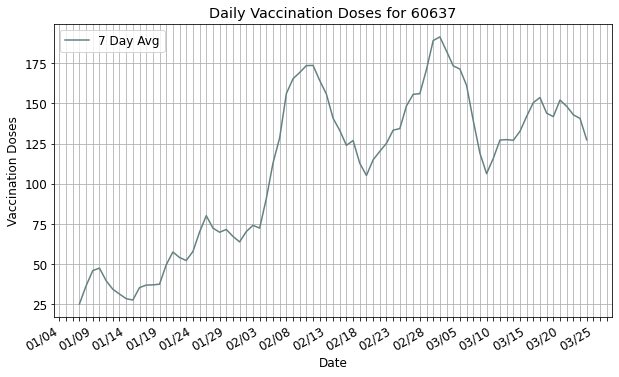

In [3]:
%matplotlib inline

title_str = f"Daily Vaccination Doses for {zipcode_to_test}"
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(zipcode_vax_weekly[data_transformations.STD_DATE_COL_NAME],
        zipcode_vax_weekly.AVG7DAY_total_doses_daily, color='#648181', linestyle='solid', label='7 Day Avg')

ax.set_xlabel('Date')
ax.set_ylabel('Vaccination Doses')
ax.set_title(title_str)
ax.grid(True)
ax.legend(loc='upper left');
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))

every_nth = 5
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
        
fig.autofmt_xdate()